# STAT 201 Project Report: Analyzing Vancouver Bike Theft Before and After the COVID-19 Pandemic

**Group 15: Jossie Jiang and Rachel Lee**

In [5]:
set.seed(8888)
inferURL <- "https://cran.r-project.org/src/contrib/Archive/infer/infer_0.5.3.tar.gz"

install.packages(inferURL, repos=NULL, type="source")

Warning message in install.packages(inferURL, repos = NULL, type = "source"):
"installation of package 'C:/Users/rache/AppData/Local/Temp/Rtmpqcnek4/downloaded_packages/infer_0.5.3.tar.gz' had non-zero exit status"

# Introduction

## Research question:
Is the proportion of bike theft crime different in Kitsilano between before COVID-19 pandemic (from 2016 to 2018) and had this changed after it (from 2019 to 2021)?

Random Variable: The proportion of bike theft over all the crimes that happened in Kitsilano

Category Variable1: Bike theft v.s. other crime types

Category Variable2: three years before pandemic (2016-2018) v.s. three years after pandemic (2019-2021)

## Dataset:
The dataset we will be using is the Vancouver crime dataset provided by: https://geodash.vpd.ca/opendata/ . It contains the years, classifications, times, and locations of various crimes that have occurred in Vancouver starting from 2003 up to the present date. At the time this project was completed, there were 801,197 observations.

We will specifically be looking at the TYPE (indicates the type of crime), YEAR (indicates the year the crime occured), and NEIGHBOURHOOD (indicates the neighbourhood the crime occured in) variables. The dataset also includes the month/day/hour/minute of the crime, the hundred block where the crime haappened, and geographic x and y coordinates, although we will not be examining these variables since they aren't relevant in our analysis.

## Background:
Crime rates in Vancouver are constantly fluctuating. The COVID-19 pandemic in particular has drastically affected crime rates in the city of Vancouver. Local police recorded a 21.7% rise in serious assaults in the first half of 2020 (1). Since most businesses closed and were left unattended, break-ins to commercial buildings increased by 47.9% (1). As restrictions loosened in late 2020, breaking and entering crimes began to subside, as well as domestic assault (2). From this, it seems that general crimes across the city peaked during the COVID-19 lockdown period and are decreasing as everything returns back to normal.

The city of Vancouver is known for it's numerous cycling trails as a convenient mode of transportation or a fun recreational activity. Vancouverites enjoy frequent biking no matter what the weather, so there are usually lots of bikes around. This provides plenty of opportunity for thieves to strike, especially as bike sales rapidly escalated during the pandemic (5). In fact, Vancouver has the most bike thefts per capita compared to other major Canadian cities (3). In 2020 alone, 334 bicycles were stolen for every 100,000 people (3). 

Police often investigate larger cases of bike theft, especially if expensive bikes were stolen, like high-end road bikes, mountain bikes, or e-bikes. Most recently (July 2021), Vancouver police recovered $45,000 in stolen bikes, so bike theft is still a relevant issue (4). This project seeks to determine if there is a difference in the proportion of bikes stolen in the city of Vancouver before and during the coronavirus pandemic. Take note that we will be considering "during the pandemic" as thefts from 2019 to the present, and "before the pandemic" as thefts from 2016 to 2018.

# Reading Data

Here we are loading libraries we will use throught our report, as well as reading our dataset into R.

In [6]:
library(readr)
library(tidyverse)
library(repr)
library(digest)
library(ggplot2)
library(cowplot)
library(infer)
library(broom)

myurl <- "https://raw.githubusercontent.com/NicTavares/VancouverCrimeStats/master/crimedata_csv_all_years.csv"

crime_data<-read_csv(url(myurl))
head(crime_data)

ERROR: Error in library(readr): there is no package called 'readr'


# Cleaning the Data

Here we selected variables that are relevant to our analysis and ensured that each observation we use holds some value. We also created a new variable called "period" that categorizes an observation as 'after pandemic' (2019-2021) or 'before pandemic' (2016-2018) based on it's year. Additionally, we added the variables "all_crimes_number" and "bike_theft_number", which represent the total amount of crimes occured in a year and the total amount of bike thefts in a year respectively. Finally, we calculated the proportion of crimes that are bike thefts (bike crimes/total crimes) for each year, which is under the "prop" variable.

In [233]:
crime_data_clean <- subset(crime_data, select = c(TYPE, YEAR, NEIGHBOURHOOD)) %>%
    filter(!is.na(TYPE)) %>%
    filter(!is.na(YEAR)) %>%
    filter(!is.na(NEIGHBOURHOOD)) %>%
    filter(NEIGHBOURHOOD == 'Kitsilano' & YEAR >= 2016) %>%
    mutate(PERIOD = if_else(YEAR > 2018, 'after pandemic', 'before pandemic'))

colnames(crime_data_clean) <- c('type', 'year', 'neighbourhood', 'period')

theft_data_clean <- crime_data_clean %>%
    group_by(year) %>%
    mutate(all_crimes_number = n()) %>%
    filter(type == 'Theft of Bicycle') %>%
    group_by(type, year) %>%
    mutate(bike_theft_number = n()) %>%
    mutate(prop = bike_theft_number/all_crimes_number)

head(crime_data_clean)
head(theft_data_clean)

type,year,neighbourhood,period
<chr>,<dbl>,<chr>,<chr>
Theft from Vehicle,2020,Kitsilano,after pandemic
Theft from Vehicle,2020,Kitsilano,after pandemic
Theft from Vehicle,2020,Kitsilano,after pandemic
Theft from Vehicle,2021,Kitsilano,after pandemic
Theft from Vehicle,2018,Kitsilano,before pandemic
Theft from Vehicle,2017,Kitsilano,before pandemic


type,year,neighbourhood,period,all_crimes_number,bike_theft_number,prop
<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<dbl>
Theft of Bicycle,2016,Kitsilano,before pandemic,2060,193,0.09368932
Theft of Bicycle,2019,Kitsilano,after pandemic,1911,162,0.08477237
Theft of Bicycle,2019,Kitsilano,after pandemic,1911,162,0.08477237
Theft of Bicycle,2020,Kitsilano,after pandemic,1793,220,0.12269939
Theft of Bicycle,2017,Kitsilano,before pandemic,1870,205,0.10962567
Theft of Bicycle,2019,Kitsilano,after pandemic,1911,162,0.08477237


# Basic Plots

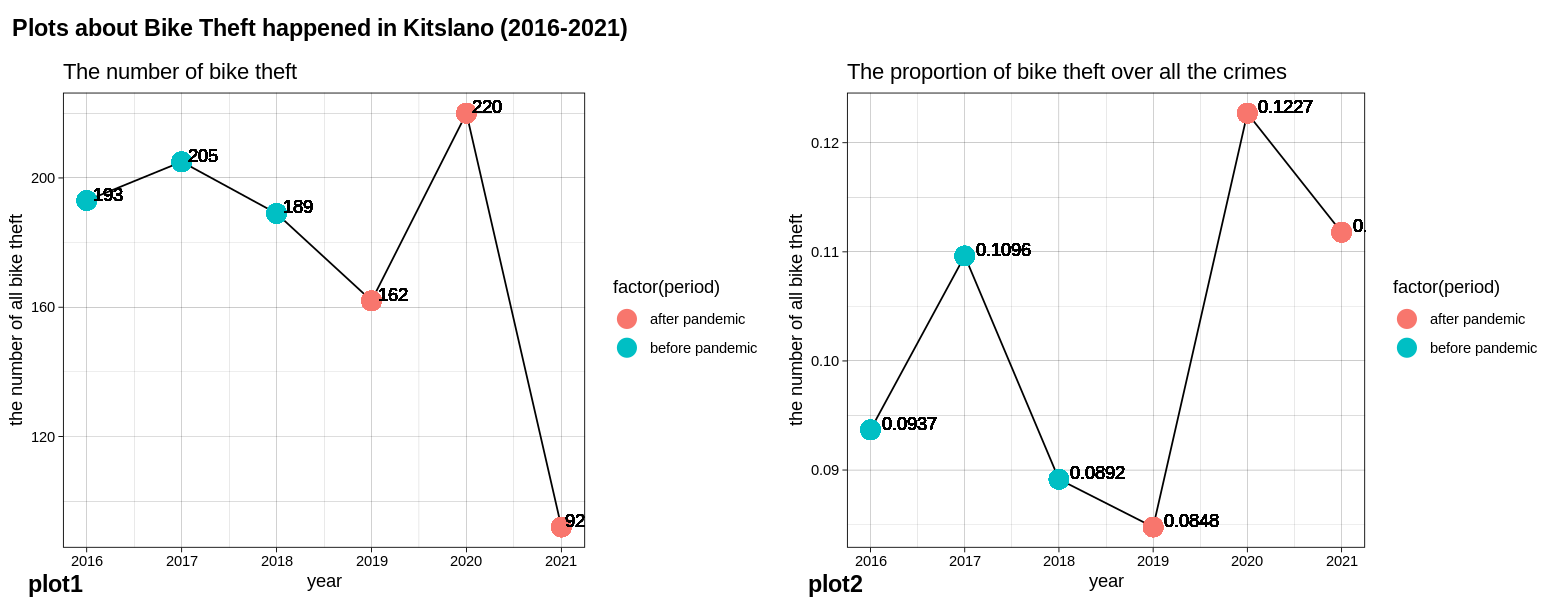

In [313]:
# plotting the number of bike theft from 2016 to 2021
theft_number_plot <- ggplot(data = theft_data_clean, aes(x = year, y= bike_theft_number, group=1)) +
    geom_line() +
    geom_point(aes(color = factor(period)), size = 5 ) + 
    geom_text(aes(label = bike_theft_number),hjust=-0.2, vjust=0) + 
    ggtitle('The number of bike theft') +
    labs(x = "year", y = "the number of all bike theft") +
    theme_linedraw()
options(repr.plot.width = 13, repr.plot.height = 5)

theft_prop_plot <- ggplot(data = theft_data_clean, aes(x = year, y= prop, group=1)) +
    geom_line() +
    geom_point(aes(color = factor(period)), size = 5 ) + 
    geom_text(aes(label = prop %>% round(4)),hjust=-0.2, vjust=0) + 
    ggtitle('The proportion of bike theft over all the crimes') +
    labs(x = "year", y = "the number of all bike theft") +
    theme_linedraw()

options(repr.plot.width = 13, repr.plot.height = 5)

title <- ggdraw() + 
  draw_label(
    "Plots about Bike Theft happened in Kitsilano (2016-2021)",
    fontface = 'bold',
    x = 0,
    hjust = 0
  ) +
  theme(
    plot.margin = margin(0, 0, 0, 7)
  )

plot_row <- plot_grid(theft_number_plot, theft_prop_plot, labels = c('plot1', 'plot2'), label_x = 0, label_y = 0,
  hjust = -0.5, vjust = -0.5)
plot_grid(
  title, plot_row,
  ncol = 1,
  rel_heights = c(0.1, 1)
)

We used the above line graphs to show the number of bike thefts per year (plot1) as well as the proportion of bike thefts per year (plot2). Both plots are colour coordinated to show whether the statistic was calculated before (turquoise) or after/during (coral) the pandemic. Note that here we are using our population data.

From these graphs we can roughly see that the number of bike thefts and the proportion of bike thefts over all crimes in the Kitsilano neighbourhood have a positive trend.

# Sampling

Here we will be taking 500 samples of size 500 for our data both before and after the pandemic. We are sampling without replacement, these samples are taken from the population. We also take an extra precaution here to make sure that all observations in the sample are bike thefts and not any other type of theft.

In [235]:
set.seed(88)

before_pandemic <- crime_data_clean %>%
    filter(period == 'before pandemic') %>%
    select(-year)

after_pandemic <- crime_data_clean %>%
    filter(period == 'after pandemic') %>%
    select(-year)

before_pandemic_samples <- before_pandemic %>%
    rep_sample_n(size = 500, rep = 500, replace = FALSE) %>%
    group_by(replicate) %>%
    filter(type == 'Theft of Bicycle') %>%
    mutate(bike_theft_number = n()) %>%
    mutate(prop = bike_theft_number/500) %>%
    filter(!duplicated(replicate))
    

after_pandemic_samples <- after_pandemic %>%
    rep_sample_n(size = 500, rep = 500, replace = FALSE) %>%
    group_by(replicate) %>%
    filter(type == 'Theft of Bicycle') %>%
    mutate(bike_theft_number = n()) %>%
    mutate(prop = bike_theft_number/500) %>%
    filter(!duplicated(replicate))

head(before_pandemic_samples)
head(after_pandemic_samples)

replicate,type,neighbourhood,period,bike_theft_number,prop
<int>,<chr>,<chr>,<chr>,<int>,<dbl>
1,Theft of Bicycle,Kitsilano,before pandemic,42,0.084
2,Theft of Bicycle,Kitsilano,before pandemic,53,0.106
3,Theft of Bicycle,Kitsilano,before pandemic,43,0.086
4,Theft of Bicycle,Kitsilano,before pandemic,48,0.096
5,Theft of Bicycle,Kitsilano,before pandemic,45,0.090
6,Theft of Bicycle,Kitsilano,before pandemic,56,0.112


replicate,type,neighbourhood,period,bike_theft_number,prop
<int>,<chr>,<chr>,<chr>,<int>,<dbl>
1,Theft of Bicycle,Kitsilano,after pandemic,64,0.128
2,Theft of Bicycle,Kitsilano,after pandemic,55,0.110
3,Theft of Bicycle,Kitsilano,after pandemic,60,0.120
4,Theft of Bicycle,Kitsilano,after pandemic,55,0.110
5,Theft of Bicycle,Kitsilano,after pandemic,44,0.088
6,Theft of Bicycle,Kitsilano,after pandemic,56,0.112


# Sampling Distributions

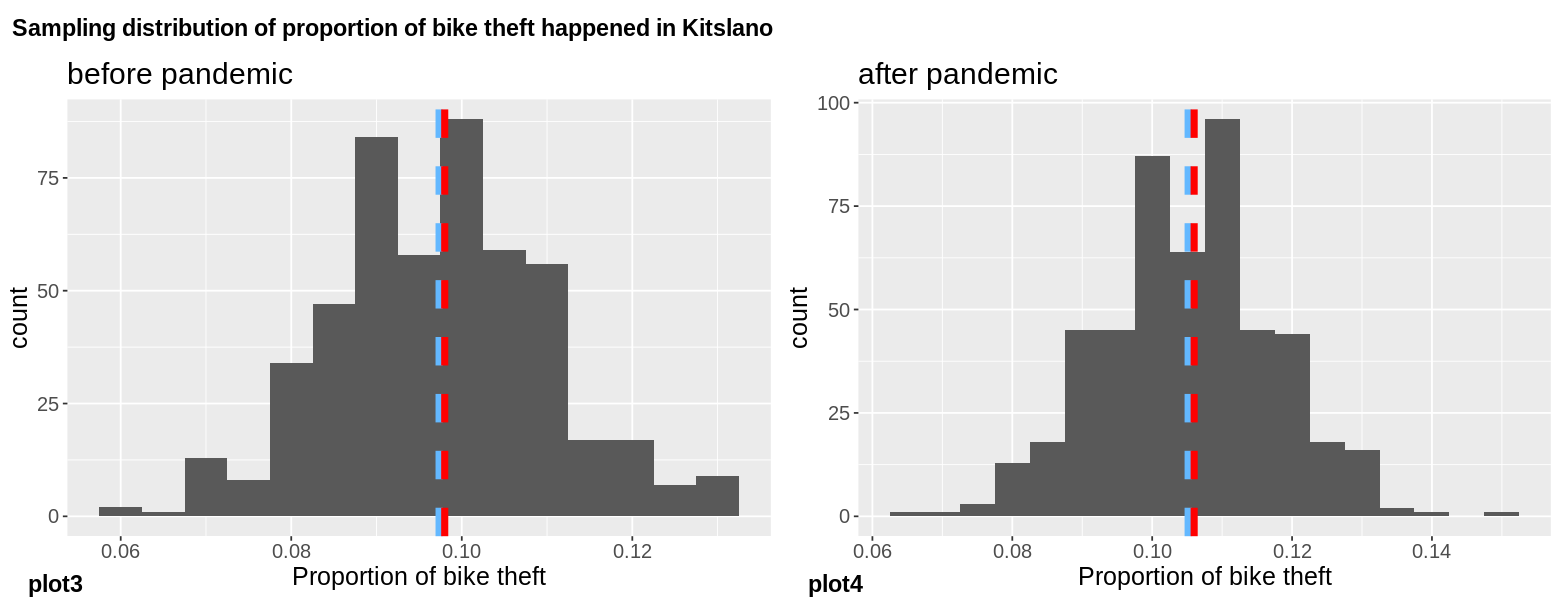

In [316]:
before_pandemic_sampling_distribution <- before_pandemic_samples %>%
    ggplot(aes(x = prop))+
    geom_histogram(binwidth = 0.005) +
    ggtitle("before pandemic") +
    labs(x = "Proportion of bike theft") +
    theme(text = element_text(size = 15)) +
    geom_vline(aes(xintercept = mean(prop)), size=2, color='steelblue1', linetype='dashed') +
    geom_vline(aes(xintercept = median(prop)), size=2, color='red', linetype='dashed')


after_pandemic_sampling_distribution <- after_pandemic_samples %>%
    ggplot(aes(x = prop))+
    geom_histogram(binwidth = 0.005) +
    ggtitle("after pandemic") +
    labs(x = "Proportion of bike theft") +
    theme(text = element_text(size = 15)) + 
    geom_vline(aes(xintercept = mean(prop)), size=2, color='steelblue1', linetype='dashed') +
    geom_vline(aes(xintercept = median(prop)), size=2, color='red', linetype='dashed')

title <- ggdraw() + 
  draw_label(
    "Sampling distribution of proportion of bike theft happened in Kitsilano",
    fontface = 'bold',
    x = 0,
    hjust = 0
  ) +
  theme(
    plot.margin = margin(0, 0, 0, 7)
  )

plot_row <- plot_grid(before_pandemic_sampling_distribution, after_pandemic_sampling_distribution, labels = c('plot3', 'plot4'), label_x = 0, label_y = 0,
  hjust = -0.5, vjust = -0.5)

plot_grid(
  title, plot_row,
  ncol = 1,
  rel_heights = c(0.1, 1)
)

Here we have two histograms above showing the sampling distributions of the sample proportions of bike theft in Kitsilano before and after the pandemic. The vertical blue-dotted line shows the median proportion of bike theft while the red one shows the mean proportion of bike theft.

Both graphs are roughly unimodal and bell-shaped (normal). This outcome is as expected, since we can apply the Central Limit Theorem (CLT) here. CLT states that the sampling distribution of sample proportion will be similar to a normal distribution, given that sample size n is big enough (typically anything over 30 works). We can also see that the mean and median proportion of bike theft is higher after the pandemic than before the pandemic.

# Hypothesis Testing
Objective: We want to see if COVID-19 implicitly encourages bike theft that happened in Kitsilano.

Null Hypothesis (H0): The proportion of bike theft that happened in Kitsilano after the pandemic is as the same as that before the pandemic.

Alternative Hypothesis (HA): The proportion of bike theft that happened in Kitsilano after the pandemic is larger than that before the pandemic.

<b>Method1: Hypothesis Testing by Boostrap<b>

Below we used a two-sample t-test for our hypothesis test. This is because the population standard deviation is unknown to us, which is a requirement for the z-test, so we can't use a z-test.

First we take a sample of 500 observations for each before the pandemic and after the pandemic. Next, we create a new column called 'Theft of Bicyle' to make sure that the theft type of the observation is bicycle theft. Then, we create the null distribution, calculate relevant test statistics, find the p-value, and finally plot the null distribution.

replicate,type,neighbourhood,period,is_bicycle_theft
<int>,<chr>,<chr>,<chr>,<lgl>
1,Theft of Bicycle,Kitsilano,before pandemic,TRUE
1,Break and Enter Residential/Other,Kitsilano,before pandemic,FALSE
1,Theft of Bicycle,Kitsilano,before pandemic,TRUE
1,Theft of Bicycle,Kitsilano,before pandemic,TRUE
1,Theft from Vehicle,Kitsilano,before pandemic,FALSE
1,Theft from Vehicle,Kitsilano,before pandemic,FALSE


[1] 0.026

replicate,stat
<int>,<dbl>
1,0.018
2,-0.002
3,-0.014
4,0.002
5,-0.010
6,0.018


p_value
<dbl>
0.115


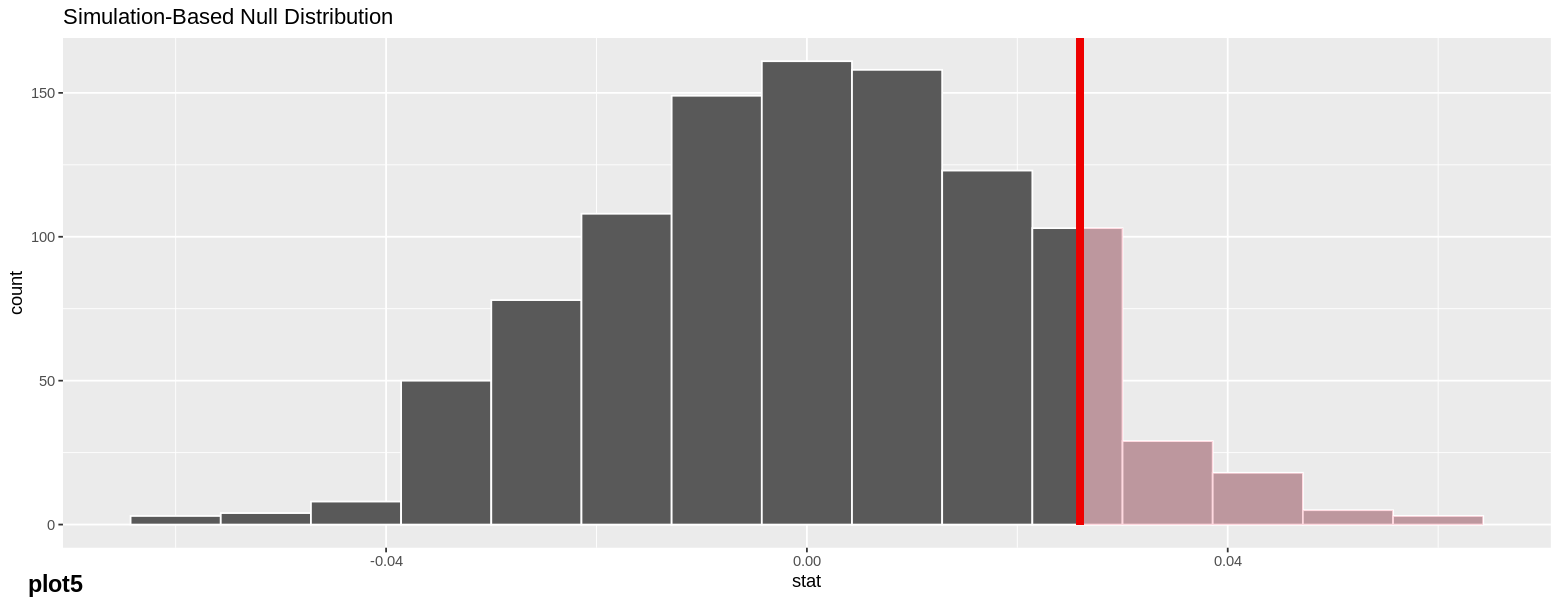

In [319]:
set.seed(2001)
before_pandemic_sample <- before_pandemic %>%  
    rep_sample_n(size = 500)
    

after_pandemic_sample <- after_pandemic %>%
    rep_sample_n(size = 500)

samples <- rbind(before_pandemic_sample, after_pandemic_sample) %>%
    mutate(is_bicycle_theft = (type == 'Theft of Bicycle'))

head(samples)

null_dist_bt <- 
    samples %>%
    specify(formula = is_bicycle_theft ~ period, success= 'TRUE') %>%
    hypothesize(null = 'independence') %>%
    generate(reps = 1000, type = 'permute') %>%
    calculate(stat = 'diff in props', order = c('after pandemic', 'before pandemic'))

obs_prop_diff <-
    samples %>%
    specify(formula = is_bicycle_theft ~ period, success= 'TRUE') %>%
    calculate(stat = 'diff in props', order = c('after pandemic', 'before pandemic')) %>%
    pull()

visual_plot <- visualize(null_dist_bt) +
 shade_p_value(obs_stat = obs_prop_diff, direction='right')

null_distribution_plot <- plot_grid(visual_plot, labels = c('plot5'), label_x = 0, label_y = 0,
  hjust = -0.5, vjust = -0.5)

p_value_bt <- null_dist_bt %>% get_p_value(obs_stat = obs_prop_diff, direction='right')

obs_prop_diff
head(null_dist_bt)
p_value_bt
null_distribution_plot

<b>P-Value<b>

Our p-value tells us the probability that the proportion of bike theft after the pandemic is greater than the proportion of bike theft before the pandemic occured by random chance assuming the null distribution is true. Given that our p-value is  0.115, there is a 11.5% chance that the proportion of bike theft after the pandemic is greater than that before happened by chance. We will further explore this later in the "Discussion" section of this report.

<b>plot5: Simulation-Based Null Distribution<b>

We generated our null distribution using the infer package. The vertical red line is equal to the observed difference in proportions of bike theft before and after the pandemic, which is 0.026. We shaded the area to the right of that line because we are testing whether or not the proportion of bike theft after the pandemic is greater than the proportion of bike theft before the pandemic.

<b>Method2: Hypothesis Testing by CLT<b>

In [268]:
prop_test <- 
prop.test(
            x = c(samples %>% filter(is_bicycle_theft == 'TRUE' & period == 'after pandemic') %>% nrow(), 
			samples %>% filter(is_bicycle_theft == 'TRUE' & period == 'before pandemic') %>% nrow()), 
            n = c(500, 500), 
            alternative = 'greater', 
            correct = FALSE) %>% 
	tidy()

prop_test

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.122,0.096,1.740133,0.09356097,1,-0.006391507,1,2-sample test for equality of proportions without continuity correction,greater


We used the prop.test() function above. This returns detailed information about our hypothesis test. We note that it outputs a lower p-value than we calculated earlier, 0.093, compared to 0.115. Despite this difference, both will lead us to not reject the null hypothesis, which is further discussed in the "Discussion" section.

# Confidence Interval

Here we calculate a 95% confidence interval (CI) of the difference in proportions. Based on the values we got below, if we were to take the difference in proportions 100 times, 95 of those times the value of the difference in proportions would lie between -0.0125 (lower CI) and 0.064 (upper CI).

In [306]:
before_count <- before_pandemic_sample %>%
    filter(type == 'Theft of Bicycle') %>%
    count()

after_count <- after_pandemic_sample %>%
    filter(type == 'Theft of Bicycle') %>%
    count()

before_prop <- before_pandemic_count$n[1]/500
after_prop <- after_pandemic_count$n[1]/500
before_sd <- sqrt(before_prop*(1-before_prop)/500)
after_sd<- sqrt(after_prop*(1-after_prop)/500)

sd_diff <- sqrt(before_sd^2 + after_sd^2) # standard error for difference

prop_diff <- after_prop - before_prop # difference between the sample proportions


conf_low_95 <- prop_diff+qnorm(0.025)*sd_diff
conf_high_95 <- prop_diff+qnorm(0.975)*sd_diff

conf_low_95
conf_high_95

[1] -0.01259686

[1] 0.06459686

# Methods & Results

## In what ways is this report trustworthy?
Our report is trustworthy because...
* The dataset is from an authority site. The data we used in our analysis is from the Official Website of the Vancouver Police Department and the City of Vancouver. Given this reputable source, we believe the dataset to be unbiased and truthful.

* The sample size is large enough. With a sample size of 500, we are able to apply the central limit theorem (this is mentioned earlier with our sampling distribution histograms).

* The sample is representative and random. Our samples were taken without replacement and with a large sample size, allowing our samples to be taken at random and are therefore representative.

## What do you expect to find? 

We expect to find that COVID-19 pandemic happened in 2019 leads to higher proportion of bike theft in Kitsilano. 

## Do you think one of bootstrapping or asymptotics is more appropriate than the other? Why or why not? Explain why you think both methods gave you similar/different results, and whether you think one is more trustworthy than the other.
We think asymptotics is a better approach since we conducted a two-sample t-test for the difference in proportions. Each method gave us different p-values. From the method 1 (hypothesis testing by bootstrap), we calculated a p-value of around 0.093. With method 2 (hypothesis testing by CLT), we calculated a p-value of 0.115. This may be because of the variability in the bootstrap method, as we could get different bootstrap samples each time.

# Discussion

## Summarize what you found, and the implications/impact of your findings.

Our goal was to determine if the proportion of bike theft in Kitsilano from before the COVID-19 pandemic increased after the pandemic or not. Thus, our null hypothesis is that the proportions are equal and our alternative hypothesis is that the proportion of bike theft in Kitsilano after the pandemic is greater than that of before. In the end, we resulted with not rejecting our null hypothesis. This decision is supported by our calculated p-value, which is 0.115, with a significance level of 5% (0.05 < 0.115 = we do not reject the null hypothesis).

Based on the articles mentioned in the introduction (CBC News and CTV News), we suspected that bike theft would rise during the pandemic due to higher cases of general theft in and an increase in bike sales as eager Vancouverites seek to stay fit. Hence, our analyses support our initial expectations.

Knowing that the proportion of bike theft crimes in Vancouver have risen, this information may be of use to the Vancouver Police Department (VPD), who could use this to encourage more Vancouverites to purchase better quality bike locks, make sure more police officers know how to react in a bike theft situation, or update their protocals in preparation for a higher volume of bike thefts in the Kitsilano neighbourhood. The City of Vancouver could also launch an initiative to upgrade public bike storage options or place more secure bike racks around the Kitsilano area.

If we were to continue our analysis, we could include the day, minute, and hour variables to identify peak times of bike theft. Our results from this expansion could help inform the VPD on how to allocate their resources the most effectively (i.e., have more staff scheduled and staff experienced with bike theft at peak hours) to prevent the most crimes. This idea could also be applied to crimes of any time in any neighbourhood.

Given these results, we have the following questions for future discussion/research:
* How does the proportion of bike theft before and after COVID vary between neighbourhoods We conducted our analysis exclusively on bike theft in the Kitsilano neighbourhood, how would it compare to other neighbourhoods? This could lead to identifying which neighbourhoods more frequently use biking as a mode of transportation, or bring up other questions, for example: Is bike theft higher in wealthier communities?

* If we wait a few years until the coronavirus is completely gone, would the proportion of bike theft in the Kitsilano neighbourhood return to how it was prior to the pandemic?

* Are bikes with certain characteristics more likely to be stolen than others? Characteristics could include accessories (bells, baskets, fenders, paniers, etc.), colour, size, or brand.

* We are also interested in using the remaining variables in our dataset (hundred_block, x, y [x and y are coordinates]) to determine bike theft hot spots in the Kitsilano neighbourhood.

* How does Vancouver the proportion of bike theft before/after the pandemic compare to major cities in other countries? 

**References**

(1)The Canadian Press. (2020, September 17). Vancouver police record increase in violent crime, decrease in property crime in the first half of 2020. CBCnews. https://www.cbc.ca/news/canada/british-columbia/vancouver-police-increase-violent-crime-decrease-property-crime-1.5728664.

(2)Uguen-Csenge, E. (2021, June 27). Here's what happened to crime rates in Vancouver during the pandemic | CBC News. CBCnews. https://www.cbc.ca/news/canada/british-columbia/here-s-what-happened-to-crime-rates-in-vancouver-during-the-pandemic-1.6078015.

(3)Ballard, J. (2021, February 4). Vancouver still has the most bike thefts per capita among major Canadian cities, despite efforts. CBC News. https://www.cbc.ca/news/canada/british-columbia/vancouver-still-has-the-most-bike-thefts-per-capita-among-major-canadian-cities-despite-efforts-1.5898575

(4)CTVNewsVancouver.ca Staff. (2021, July 23). $45,000 in stolen bikes recovered in Vancouver; police hoping to return them to owners. CTV News. https://bc.ctvnews.ca/45-000-in-stolen-bikes-recovered-in-vancouver-police-hoping-to-return-them-to-owners-1.5520817

(5)Uguen-Csenge, E. (2020, May 18). Bike sales spike as Vancouverites look for fitness and travel alternatives during COVID-19. CBC News. https://www.cbc.ca/news/canada/british-columbia/bike-sales-spike-vancouver-covid-travel-1.5572344